# Amsterdam Listing

Let's import useful packages:

In [1]:
import gzip
import json
import csv
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import numpy as np

Pandas is a powerful and flexible library. Specifying the compression type we are able to read gzip files, a compression for huge csv files. In this case, we have set low memory as False because some columns have mixed types. Another recommendation is to establish the data types, but in csv there is not a complement file or extra information to know that.

In [4]:
listing = pd.read_csv('dataset/listings.csv.gz', compression='gzip',
                   error_bad_lines=False, low_memory=False)

`info()` and `head()` provide us the big picture of listing data

In [5]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20025 entries, 0 to 20024
Columns: 106 entries, id to reviews_per_month
dtypes: float64(23), int64(21), object(62)
memory usage: 16.2+ MB


In [6]:
listing.drop_duplicates(inplace=True)

In [7]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20025 entries, 0 to 20024
Columns: 106 entries, id to reviews_per_month
dtypes: float64(23), int64(21), object(62)
memory usage: 16.3+ MB


In [8]:
listing.head()

id                         listing_url       scrape_id last_scraped  \
0   2818   https://www.airbnb.com/rooms/2818  20191207212953   2019-12-08   
1  20168  https://www.airbnb.com/rooms/20168  20191207212953   2019-12-08   
2  25428  https://www.airbnb.com/rooms/25428  20191207212953   2019-12-08   
3  27886  https://www.airbnb.com/rooms/27886  20191207212953   2019-12-08   
4  28871  https://www.airbnb.com/rooms/28871  20191207212953   2019-12-08   

                                                name  \
0           Quiet Garden View Room & Super Fast WiFi   
1       Studio with private bathroom in the centre 1   
2    Lovely apt in City Centre (w.lift) near Jordaan   
3  Romantic, stylish B&B houseboat in canal district   
4                            Comfortable double room   

                                             summary  \
0           Quiet Garden View Room & Super Fast WiFi   
1  17th century Dutch townhouse in the heart of t...   
2                                                NaN   
3  Stylish and romantic houseboat on fantastic hi...   
4                                                NaN   

                                               space  \
0  I'm renting a bedroom (room overlooking the ga...   
1  For those who like all facets of city life. In...   
2  This nicely furnished, newly renovated apt  is...   
3  For a romantic couple: A beautifully restored ...   
4  In a monumental house right in the center of A...   

                                         description experiences_offered  \
0  Quiet Garden View Room & Super Fast WiFi I'm r...                none   
1  17th century Dutch townhouse in the heart of t...                none   
2  This nicely furnished, newly renovated apt  is...                none   
3  Stylish and romantic houseboat on fantastic hi...                none   
4  In a monumental house right in the center of A...                none   

                               neighborhood_overview        ...          \
0  Indische Buurt ("Indies Neighborhood") is a ne...        ...           
1  Located just in between famous central canals....        ...           
2                                                NaN        ...           
3         Central, quiet, safe, clean and beautiful.        ...           
4                                                NaN        ...           

  instant_bookable is_business_travel_ready          cancellation_policy  \
0                t                        f  strict_14_with_grace_period   
1                f                        f  strict_14_with_grace_period   
2                f                        f  strict_14_with_grace_period   
3                t                        f  strict_14_with_grace_period   
4                f                        f                     moderate   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             f                                f   
2                             f                                f   
3                             f                                f   
4                             f                                f   

   calculated_host_listings_count  \
0                               1   
1                               2   
2                               2   
3                               1   
4                               3   

   calculated_host_listings_count_entire_homes  \
0                                            0   
1                                            0   
2                                            2   
3                                            0   
4                                            0   

  calculated_host_listings_count_private_rooms  \
0                                            1   
1                                            2   
2                                            0   
3                                 

A brief inspection of columns enable us to split them according to the following **different categories of information**:

1. **General information of booking**: id, name, summary, description, space, experiences_offered, neighborhood overview, notes, transit, access, interaction, house_rules. To access that, select columns from `id` to `house_rules`.

2. **Host information**: id, name, location, about, response time, response rate, acceptance rate, listings count, verifications. In this case, select columns from `host_id` to `host_identity_verified`.

3. All about the **neighborhood**: city, state, market, cleansed. Extract this information selecting columns from `street` to `is_location_exact`.

4. Details of **property and conditions** are between the columns `property_type` and `maximum_nights_avg_ntm`.

5. **Calendar updates and availability** the next 30, 60 and 90 days, for instances. You can find this information between the columns `calendar_updated` and `calendar_last_scraped`.

6. **Reviews**: first and last review, number of reviews, scores rating, scores per accuracy, cleanliness, checkin, communication, location and value. Columns from `number of reviews` to `review_scores_value`.

7. **Verifications and licenses**: require guest profile picture, phone verification, cancellation policy, instant bookeable. Columns from `requires_license` to `require_guest_phone_verification`.

8. **Host listings counts** and reviews per month. Select from `calculated_host_listings_count` to `reviews_per_month`.

## 1. General information of booking

This section will be develop in details in further notebooks to apply Natural Language Processing to resolve the following challenges:

1. Empty summaries: Can we use the rest columns to create a summary for litings without one?
2. Common elements in Transit 
3. Common elements in house rules

In [9]:
booking_records = listing.loc[:, 'id':'house_rules']

In [10]:
booking_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20025 entries, 0 to 20024
Data columns (total 15 columns):
id                       20025 non-null int64
listing_url              20025 non-null object
scrape_id                20025 non-null int64
last_scraped             20025 non-null object
name                     19991 non-null object
summary                  19390 non-null object
space                    14654 non-null object
description              19783 non-null object
experiences_offered      20025 non-null object
neighborhood_overview    13641 non-null object
notes                    8389 non-null object
transit                  13922 non-null object
access                   11334 non-null object
interaction              12094 non-null object
house_rules              12215 non-null object
dtypes: int64(2), object(13)
memory usage: 2.4+ MB


## 2. Host Information

In [11]:
host_information = listing.loc[:, 'host_id': 'host_identity_verified']

In [12]:
host_information.drop_duplicates(inplace=True)

In [13]:
host_information.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17502 entries, 0 to 20024
Data columns (total 18 columns):
host_id                      17502 non-null int64
host_url                     17502 non-null object
host_name                    17353 non-null object
host_since                   17353 non-null object
host_location                17321 non-null object
host_about                   9780 non-null object
host_response_time           8549 non-null object
host_response_rate           8549 non-null object
host_acceptance_rate         0 non-null float64
host_is_superhost            17353 non-null object
host_thumbnail_url           17353 non-null object
host_picture_url             17353 non-null object
host_neighbourhood           12048 non-null object
host_listings_count          17353 non-null float64
host_total_listings_count    17353 non-null float64
host_verifications           17502 non-null object
host_has_profile_pic         17353 non-null object
host_identity_verified       

### How many listings/host?

To avoid duplicates host_id, we select only host_id and total_listing_count, deleting the duplicates:

In [14]:
unique_host_listings = host_information.loc[:, ['host_id', 'host_total_listings_count']].reindex().drop_duplicates().dropna()

In [15]:
total_listings_count = unique_host_listings.groupby('host_total_listings_count').count()

Graphical identification of outliers:

/Users/daniela/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  self.set_xlim(upper, lower, auto=None)


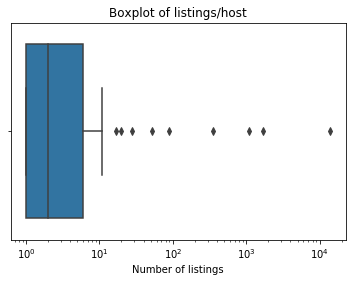

In [16]:
_ = plt.xscale('log')
_ = sns.boxplot(total_listings_count)
_ = plt.xlabel('Number of listings')
_ = plt.title('Boxplot of listings/host')

Almost all hosts have less than ten listings, but some results are a little unusual. The information is correct and it belongs to hotels chains, global marketplaces and home rental management companies. The most interesting aspect of that is their airbnb profiles look exactly the same of the rest of hosts. There is no extra information about the companies, avoiding the self promotion.

In [17]:
listing_counts = total_listings_count[(total_listings_count.index > 0) & (total_listings_count.index < 60)]

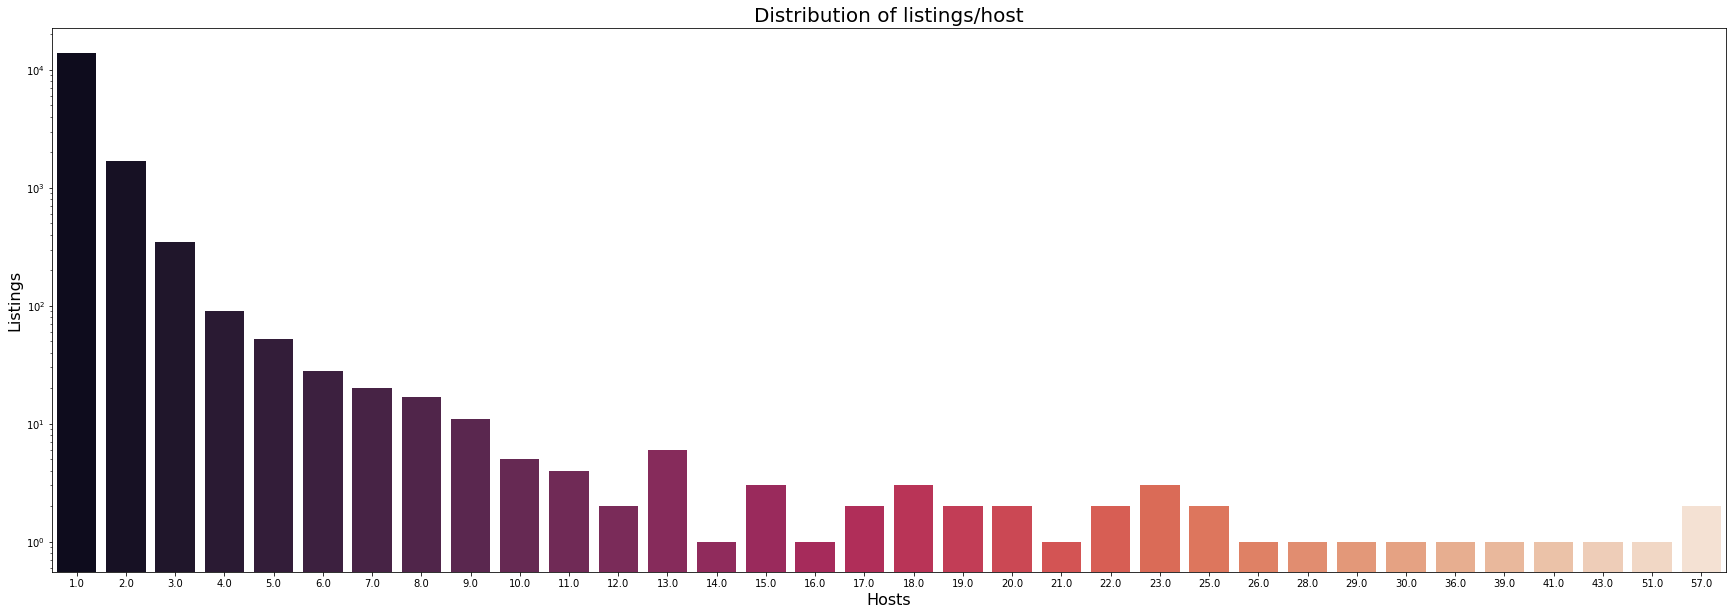

In [18]:
_ = plt.figure(figsize=(30,10))
_ = plt.yscale('log')
_ = sns.barplot(x=listing_counts.index, y=listing_counts.host_id, palette="rocket")
_ = plt.xlabel('Hosts', size=16)
_ = plt.ylabel('Listings', size=16)
_ = plt.title('Distribution of listings/host', size=20)

### Response Time of Hosts

There are 4 categories of response time:

In [19]:
response_time = host_information.groupby('host_response_time').count().host_id
response_time

host_response_time
a few days or more     327
within a day          2123
within a few hours    2170
within an hour        3929
Name: host_id, dtype: int64

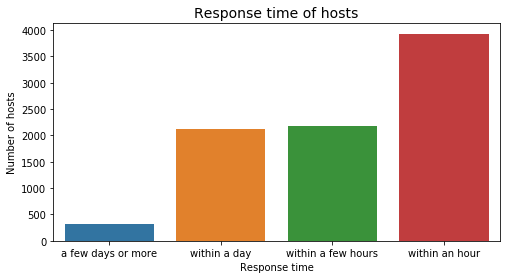

In [20]:
_ = plt.figure(figsize=(8, 4))
_ = sns.barplot(x=response_time.index, y=response_time)
_ = plt.xlabel('Response time', size=10)
_ = plt.ylabel('Number of hosts', size=10)
_ = plt.title('Response time of hosts', size=14)

And in percentages:

In [21]:
100*response_time/response_time.sum()

host_response_time
a few days or more     3.825009
within a day          24.833314
within a few hours    25.383086
within an hour        45.958592
Name: host_id, dtype: float64

According to Airbnb, the response time is the average time that hosts take to respond to all messages in the last 30 days. This includes reservation requests, pre-approve and decline trip requests and reply new inquiries from guests and doesn't consider the follow-up messages between hosts and guests. 

From the Figure below it's possible conclude that hosts response quickly to their guests: about 46% of hosts reply their requests within an hour; approximately 50% of them take a few or more hours within the same day of the request and finally, almost 4% of hosts respond a few days later or more.

### Response Rate of Hosts

The response rate is the percentage of new requests (reservations and inquiries) that the hosts responded within 24 hours in the past 30 days. Neither response time or response rate consider the follow-up messages between hosts and guests.

In [22]:
def str_rate2int(rate):
    if type(rate) is str:
        return float(rate.replace("%", ""))
    else:
        return rate 

In [23]:
host_information['host_response_rate_float'] = host_information.host_response_rate.apply(str_rate2int).dropna()

In [24]:
response_rate = host_information.groupby('host_response_rate_float').count().host_id

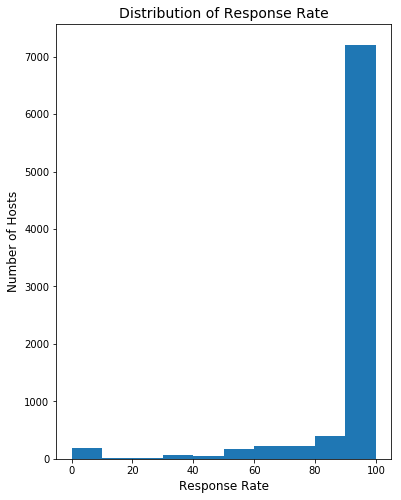

In [25]:
np.warnings.filterwarnings('ignore')

_ = plt.figure(figsize=(6,8))
_ = plt.hist(host_information['host_response_rate_float'])
_ = plt.xlabel('Response Rate', size=12)
_ = plt.ylabel('Number of Hosts', size=12)
_ = plt.title('Distribution of Response Rate', size=14)

In [26]:
response_rate_percent = response_rate/response_rate.sum()

In [27]:
print('Percentage of Hosts with a Response Rate of 100% the last 30 days: {}%'.format(response_rate_percent[100]))

Percentage of Hosts with a Response Rate of 100% the last 30 days: 0.79646742309042%


80% of hosts have respond all their messages within 24 hours the last month.

1. General information. Create a summary in empty listings using the information in the rest of columns (description, space, experiences_offered, neighborhood overview, notes, transit, access, interaction, house_rules)
2. Analisis of host: from 'host_id' to 'host_identity_verified'
3. Analisis of neighborhood: from 'street' to 'is_location_exact'
4. Details of property and conditions: from 'property_type' to ;maximum_nights_avg_ntm'

2. Analisis of security checks: require guest profile picture, phone verification, cancellation policy, instant bookeable
3. Neighborhood overview with respect to the demand (reviews, rating)
4. Type of host: entire home, private rooms, shared rooms and guest perception of them (People prefer any of them in determine seasons, neighborhood, etc)

In [227]:
#sns.distplot(listing_counts.index, kde=False)
# _ = plt.hist(listing_counts.index, bins=30, facecolor='g', alpha=0.75)

In [92]:
#host_information.loc[host_information['host_total_listings_count'] == 751]